In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

%matplotlib inline

In [2]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

In [3]:
def OH(x, l):
    x = torch.LongTensor([[x]])
    one_hot = torch.FloatTensor(1,l)
    return one_hot.zero_().scatter_(1,x,1)

In [4]:
## "deep" Q-network 
class myDQN(nn.Module):
    def __init__(self, num_states, num_actions):
        super(myDQN, self).__init__()
        self.fc1 = nn.Linear(num_states, num_actions)
        
    def forward(self, x):
        out = self.fc1(x)
        return out

In [5]:
## take an epsilon greedy action 
def gen_action(state):
    if np.random.rand(1) < epsilon:
        state = OH(state, num_states)
        q_values = online_model(state)
        action = env.action_space.sample()

    else:
        state = OH(state, num_states)
        q_values = online_model(state)
        _, action = torch.max(q_values, 1)
        action = action.item()
        
    return action, q_values


In [6]:
def play_episode():
    print('')

In [7]:
env = gym.make('FrozenLakeNotSlippery-v0')
# env = gym.make('FrozenLake-v0')

epsilon = 0.05
gamma = 0.99
num_episodes = 2000
learning_rate = 0.01

# storage for plots
step_list = []
reward_list = []
loss_list = []
epsilon_list = []

num_states = env.observation_space.n
num_actions = env.action_space.n

online_model = myDQN(num_states, num_actions)
loss = nn.MSELoss()
optimizer = optim.Adam(online_model.parameters(), lr=learning_rate)

for episode in trange(num_episodes):
    state = env.reset()
    episode_length = 0.
    episode_reward = 0.
    episode_loss = 0.
    running_loss = 0.
    done = 0
    
    while (done == 0):
        episode_length += 1
        action, q_value = gen_action(state)
        next_state, reward, done, _ = env.step(action)
        
        if done:
            if reward == 0.0:
                reward = -1
            if reward > 0.0:
                epsilon = 1./((episode/50)+10)
            
        next_q_value = online_model(OH(next_state, num_states))
        max_next_q_value, _ = torch.max(next_q_value.data, 1)
        max_next_q_value = torch.FloatTensor(max_next_q_value)
        
        with torch.no_grad():
            target_q_value = q_value.data
            target_q_value[0,action] = reward + torch.mul(max_next_q_value, gamma)

        output = online_model(OH(state, num_states))
        train_loss = loss(output, target_q_value)
        running_loss += train_loss.item()
        
        online_model.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        episode_reward += reward
        state = next_state
        
    loss_list.append(running_loss / episode_length)
    step_list.append(episode_length)
    reward_list.append(episode_reward)
    epsilon_list.append(epsilon)
    
print('\nSuccessful episodes: {}'.format(np.sum(np.array(reward_list)>0.0)/num_episodes))


100%|██████████| 2000/2000 [00:15<00:00, 131.58it/s]



Successful episodes: 0.886


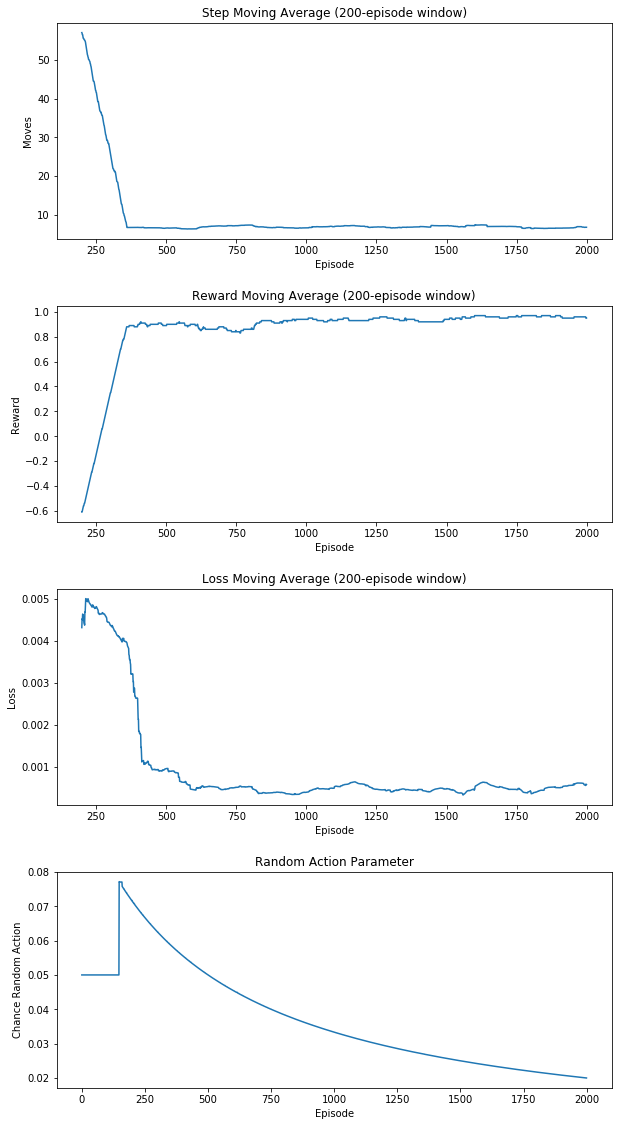

In [9]:
window = int(num_episodes/10)

plt.figure(figsize=[9,16])
plt.subplot(411)
plt.plot(pd.Series(step_list).rolling(window).mean())
plt.title('Step Moving Average ({}-episode window)'.format(window))
plt.ylabel('Moves')
plt.xlabel('Episode')

plt.subplot(412)
plt.plot(pd.Series(reward_list).rolling(window).mean())
plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.ylabel('Reward')
plt.xlabel('Episode')

plt.subplot(413)
plt.plot(pd.Series(loss_list).rolling(window).mean())
plt.title('Loss Moving Average ({}-episode window)'.format(window))
plt.ylabel('Loss')
plt.xlabel('Episode')

plt.subplot(414)
plt.plot(epsilon_list)
plt.title('Random Action Parameter')
plt.ylabel('Chance Random Action')
plt.xlabel('Episode')

plt.tight_layout(pad=2)
plt.show()